In [1]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [2]:
import pandas as pd
from skimage.io import imread as imread

from sentence_transformers import SentenceTransformer, util
import os
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("../FoodData.csv")
allergen_data = df[df.columns[-3:]]
allergen_data

,Group,Food,Allergy
0,Oil seed,Almond,Nut Allergy
1,Pome fruit,Apple,Oral Allergy Syndrome
2,Stone fruit,Apricot,Stone Fruit Allergy
3,Composite vegetable,Artichoke,Insulin Allergy
4,Liliaceous vegetable,Asparagus,Allium Allergy
...,...,...,...
179,Cereal grain,Wheat,Gluten Allergy
180,Dairy,Whey,Milk allergy / Lactose intolerance
181,Pulse,White bean,Legume Allergy
182,Potato,Yam,Potato Allergy


In [67]:
allergy_food_mapping = {}

for _, row in allergen_data.iterrows():
    group = row['Group'].lower()
    food = row['Food'].lower()
    allergy = row['Allergy']
    if not pd.isna(allergy):
        if allergy not in allergy_food_mapping:
            allergy_food_mapping[allergy] = []
        if food not in allergy_food_mapping[allergy]:
            allergy_food_mapping[allergy].append(food)
        if group not in allergy_food_mapping[allergy]:
            allergy_food_mapping[allergy].append(group)

for allergy, food_items in allergy_food_mapping.items():
    print(allergy, food_items)


Nut Allergy ['almond', 'oil seed', 'chestnut', 'ginkgo nut', 'pecan', 'walnut']
Oral Allergy Syndrome ['apple', 'pome fruit', 'avocado', 'tropical fruit', 'date', 'guava', 'japanese pear', 'kiwi', 'loquat', 'mango', 'papaya', 'passion fruit', 'pear', 'pineapple', 'quince']
Stone Fruit Allergy ['apricot', 'stone fruit', 'cherry', 'japanese plum', 'mume plum', 'nectarine', 'peach', 'prune']
Insulin Allergy ['artichoke', 'composite vegetable', 'chicory', 'endive', 'salsify', 'shungiku']
Allium Allergy ['asparagus', 'liliaceous vegetable', 'garlic', 'leek', 'nira', 'onion', 'shallot', 'welsh']
Histamine Allergy ['bamboo shoot', 'miscellaneous vegetable', 'bonito', 'fish', 'ginger', 'okra', 'spinach']
Banana Allergy ['banana', 'tropical fruit']
Gluten Allergy ['barley', 'cereal grain', 'buckwheat', 'rye', 'wheat']
Legume Allergy ['bean', 'pulse', 'black-eyed bean', 'broad bean', 'butter bean', 'green soybean', 'legumes vegetable', 'kidney bean', 'lentil', 'lima bean', 'peas', 'pegia', 'sult

In [83]:
#Ingredients
ingredients_path = '../Ingredients101'
f = open(ingredients_path + '/Annotations/ingredients_simplified.txt', "r")
ingredients = f.read().split('\n')
f.close()

#Classes
f = open(ingredients_path + '/Annotations/classes.txt', "r")
classes = f.read().split('\n')
f.close()

#Base Ingredients
f = open(ingredients_path + '/ingredients_simplification/baseIngredients.txt', "r")
base_ing = f.read().split('\n')
f.close()

#Construct dataframe for dictionary
base_ing = base_ing[0].split(",")

new_ingredients = []
for arr in ingredients:
    arr = arr.split(",")
    new_ingredients.append(arr)
    
df = pd.DataFrame({'ingredients': new_ingredients, 'target': classes})
food_df = df[:-1]
pd.set_option('display.max_colwidth', None)
food_df

,ingredients,target
0,"[butter, flour, sugar, brown sugar, apple, cinnamon, nut]",apple_pie
1,"[baby back ribs, apple, salt, mustard, brown sugar, worcestershire, gin, chili]",baby_back_ribs
2,"[nut, cinnamon, bread, butter, phyllo dough, sugar, honey, lemon, baklava]",baklava
3,"[beef, lemon, gin, salt, pepper, baby arugula, asiago]",beef_carpaccio
4,"[fat, steak, gin, shallot, parsley, capers, worcestershire, egg, black pepper, crostini]",beef_tartare
...,...,...
96,"[onion, garlic, beef, chili, salt, sugar, corn tortillas, salsa, cilantro, lime]",tacos
97,"[flour, egg, cold water, salt, konbu dashi, dashi, soy, octopus, onion, pie, cheese]",takoyaki
98,"[egg, sugar, mascarpone, brewed espresso, frangelico, rum, lady fingers, cocoa]",tiramisu
99,"[sushi grade tuna, scallions, tomato, cilantro, gin, soy, oil, cucumber]",tuna_tartare


In [84]:
# !pip install sentence-transformers

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

def check_allergies(ingredient, allergies):
    for allergy, allergens in allergy_food_mapping.items():
        for allergen in allergens:
            similarity = util.pytorch_cos_sim(
                model.encode(ingredient.lower()),
                model.encode(allergen.lower())
            ).item()
            if similarity > 0.85 and allergy not in allergies:
                allergies.add(allergy)

def process_row(row):
    allergies = set()
    for ingredient in row['ingredients']:
        check_allergies(ingredient, allergies)
    row['allergies'] = list(allergies)
    return row
food_df = food_df.apply(process_row, axis=1)
food_df

,ingredients,target,allergies
0,"[butter, flour, sugar, brown sugar, apple, cinnamon, nut]",apple_pie,"[Milk allergy / Lactose intolerance, Sugar Allergy / Intolerance, Oral Allergy Syndrome, Lactose Intolerance]"
1,"[baby back ribs, apple, salt, mustard, brown sugar, worcestershire, gin, chili]",baby_back_ribs,[Oral Allergy Syndrome]
2,"[nut, cinnamon, bread, butter, phyllo dough, sugar, honey, lemon, baklava]",baklava,"[Milk allergy / Lactose intolerance, Honey Allergy, Sugar Allergy / Intolerance, Citrus Allergy, Lactose Intolerance]"
3,"[beef, lemon, gin, salt, pepper, baby arugula, asiago]",beef_carpaccio,"[Nightshade Allergy, Citrus Allergy]"
4,"[fat, steak, gin, shallot, parsley, capers, worcestershire, egg, black pepper, crostini]",beef_tartare,"[Allium Allergy, Poultry Allergy, Hypersensitivity]"
...,...,...,...
96,"[onion, garlic, beef, chili, salt, sugar, corn tortillas, salsa, cilantro, lime]",tacos,"[Allium Allergy, Sugar Allergy / Intolerance, Citrus Allergy, Lactose Intolerance]"
97,"[flour, egg, cold water, salt, konbu dashi, dashi, soy, octopus, onion, pie, cheese]",takoyaki,"[Milk allergy / Lactose intolerance, Soy Allergy, Allium Allergy, Poultry Allergy]"
98,"[egg, sugar, mascarpone, brewed espresso, frangelico, rum, lady fingers, cocoa]",tiramisu,"[Sugar Allergy / Intolerance, Lactose Intolerance, Poultry Allergy]"
99,"[sushi grade tuna, scallions, tomato, cilantro, gin, soy, oil, cucumber]",tuna_tartare,"[Nightshade Allergy, Soy Allergy]"


In [85]:
#train
f = open(ingredients_path + '/Annotations/train_images.txt', "r")
train_images = f.read().split('\n')
f.close()
f = open(ingredients_path + '/Annotations/train_labels.txt', "r")
train_labels = f.read().split('\n')
f.close()

#val
f = open(ingredients_path + '/Annotations/val_images.txt', "r")
val_images = f.read().split('\n')
f.close()
f = open(ingredients_path + '/Annotations/val_labels.txt', "r")
val_labels = f.read().split('\n')
f.close()

#test
f = open(ingredients_path + '/Annotations/test_images.txt', "r")
test_images = f.read().split('\n')
f.close()
f = open(ingredients_path + '/Annotations/test_labels.txt', "r")
test_labels = f.read().split('\n')
f.close()

food101_path = '../archive'
image_path = food101_path + '/images/'

train_images = [image_path + s + ".jpg" for s in train_images]
train_img_df = pd.DataFrame({'path': train_images, 'class_id': train_labels})

val_images = [image_path + s + ".jpg" for s in val_images]
val_img_df = pd.DataFrame({'path': val_images, 'class_id': val_labels})

test_images = [image_path + s + ".jpg" for s in test_images]
test_img_df = pd.DataFrame({'path': test_images, 'class_id': test_labels})

train_img_df = train_img_df[:-1]
val_img_df = val_img_df[:-1]
test_img_df = test_img_df[:-1]
test_img_df

,path,class_id
0,../archive/images/apple_pie/1011328.jpg,0
1,../archive/images/apple_pie/101251.jpg,0
2,../archive/images/apple_pie/1034399.jpg,0
3,../archive/images/apple_pie/103801.jpg,0
4,../archive/images/apple_pie/1038694.jpg,0
...,...,...
25245,../archive/images/waffles/942009.jpg,100
25246,../archive/images/waffles/954028.jpg,100
25247,../archive/images/waffles/96181.jpg,100
25248,../archive/images/waffles/97015.jpg,100


In [86]:
train_img_df.loc[:, 'class_name'] = train_img_df['path'].map(lambda x: os.path.split(os.path.dirname(x))[-1])
val_img_df.loc[:, 'class_name'] = val_img_df['path'].map(lambda x: os.path.split(os.path.dirname(x))[-1])
test_img_df.loc[:, 'class_name'] = test_img_df['path'].map(lambda x: os.path.split(os.path.dirname(x))[-1])
test_img_df

,path,class_id,class_name
0,../archive/images/apple_pie/1011328.jpg,0,apple_pie
1,../archive/images/apple_pie/101251.jpg,0,apple_pie
2,../archive/images/apple_pie/1034399.jpg,0,apple_pie
3,../archive/images/apple_pie/103801.jpg,0,apple_pie
4,../archive/images/apple_pie/1038694.jpg,0,apple_pie
...,...,...,...
25245,../archive/images/waffles/942009.jpg,100,waffles
25246,../archive/images/waffles/954028.jpg,100,waffles
25247,../archive/images/waffles/96181.jpg,100,waffles
25248,../archive/images/waffles/97015.jpg,100,waffles


In [87]:
def prepare_dataset(df):
    result_df = pd.merge(df, food_df, how='left', left_on='class_name', right_on='target')
    for allergy in allergy_food_mapping.keys():
        result_df[allergy] = result_df['allergies'].apply(lambda x: 1 if allergy in x else 0)
    return result_df
train_df = prepare_dataset(train_img_df)
train_df

,path,class_id,class_name,ingredients,target,allergies,Nut Allergy,Oral Allergy Syndrome,Stone Fruit Allergy,Allium Allergy,...,Nightshade Allergy,Sugar Allergy / Intolerance,LTP Allergy,Citrus Allergy,Honey Allergy,Potato Allergy,Lactose Intolerance,Mint Allergy,Rice Allergy,Soy Allergy
0,../archive/images/apple_pie/1005649.jpg,0,apple_pie,"[butter, flour, sugar, brown sugar, apple, cinnamon, nut]",apple_pie,"[Milk allergy / Lactose intolerance, Sugar Allergy / Intolerance, Oral Allergy Syndrome, Lactose Intolerance]",0,1,0,0,...,0,1,0,0,0,0,1,0,0,0
1,../archive/images/apple_pie/1014775.jpg,0,apple_pie,"[butter, flour, sugar, brown sugar, apple, cinnamon, nut]",apple_pie,"[Milk allergy / Lactose intolerance, Sugar Allergy / Intolerance, Oral Allergy Syndrome, Lactose Intolerance]",0,1,0,0,...,0,1,0,0,0,0,1,0,0,0
2,../archive/images/apple_pie/1026328.jpg,0,apple_pie,"[butter, flour, sugar, brown sugar, apple, cinnamon, nut]",apple_pie,"[Milk allergy / Lactose intolerance, Sugar Allergy / Intolerance, Oral Allergy Syndrome, Lactose Intolerance]",0,1,0,0,...,0,1,0,0,0,0,1,0,0,0
3,../archive/images/apple_pie/1028787.jpg,0,apple_pie,"[butter, flour, sugar, brown sugar, apple, cinnamon, nut]",apple_pie,"[Milk allergy / Lactose intolerance, Sugar Allergy / Intolerance, Oral Allergy Syndrome, Lactose Intolerance]",0,1,0,0,...,0,1,0,0,0,0,1,0,0,0
4,../archive/images/apple_pie/1043283.jpg,0,apple_pie,"[butter, flour, sugar, brown sugar, apple, cinnamon, nut]",apple_pie,"[Milk allergy / Lactose intolerance, Sugar Allergy / Intolerance, Oral Allergy Syndrome, Lactose Intolerance]",0,1,0,0,...,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68170,../archive/images/waffles/981485.jpg,100,waffles,"[egg, salt, sugar, vanilla, butter, flour, baking, milk]",waffles,"[Milk allergy / Lactose intolerance, Sugar Allergy / Intolerance, Lactose Intolerance, Poultry Allergy]",0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
68171,../archive/images/waffles/98238.jpg,100,waffles,"[egg, salt, sugar, vanilla, butter, flour, baking, milk]",waffles,"[Milk allergy / Lactose intolerance, Sugar Allergy / Intolerance, Lactose Intolerance, Poultry Allergy]",0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
68172,../archive/images/waffles/982668.jpg,100,waffles,"[egg, salt, sugar, vanilla, butter, flour, baking, milk]",waffles,"[Milk allergy / Lactose intolerance, Sugar Allergy / Intolerance, Lactose Intolerance, Poultry Allergy]",0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
68173,../archive/images/waffles/995085.jpg,100,waffles,"[egg, salt, sugar, vanilla, butter, flour, baking, milk]",waffles,"[Milk allergy / Lactose intolerance, Sugar Allergy / Intolerance, Lactose Intolerance, Poultry Allergy]",0,0,0,0,...,0,1,0,0,0,0,1,0,0,0


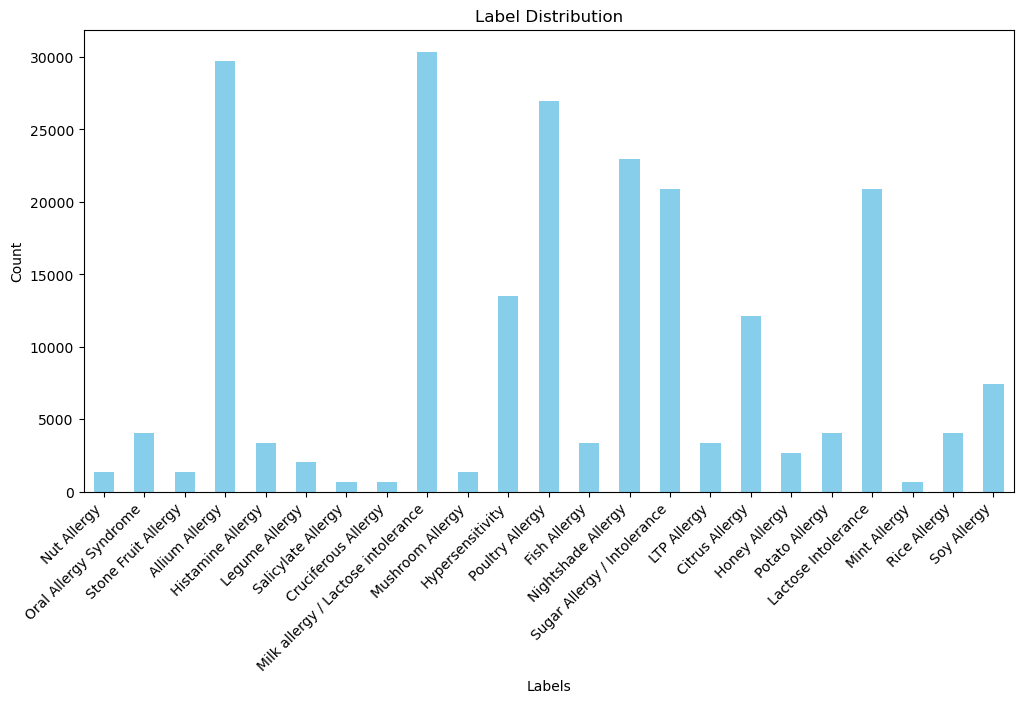

Minimum label count: 675


(23,
 Nut Allergy                            1350
 Oral Allergy Syndrome                  4050
 Stone Fruit Allergy                    1350
 Allium Allergy                        29700
 Histamine Allergy                      3375
 Legume Allergy                         2025
 Salicylate Allergy                      675
 Cruciferous Allergy                     675
 Milk allergy / Lactose intolerance    30375
 Mushroom Allergy                       1350
 Hypersensitivity                      13500
 Poultry Allergy                       27000
 Fish Allergy                           3375
 Nightshade Allergy                    22950
 Sugar Allergy / Intolerance           20925
 LTP Allergy                            3375
 Citrus Allergy                        12150
 Honey Allergy                          2700
 Potato Allergy                         4050
 Lactose Intolerance                   20925
 Mint Allergy                            675
 Rice Allergy                           4050
 Soy 

In [88]:
labels = train_df.columns[6:]
label_counts = train_df[labels].sum()
plt.figure(figsize=(12, 6))
label_counts.plot(kind='bar', color='skyblue')
plt.title('Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()
labels_greater_than_3 = label_counts[label_counts > 3]

min_label_count = labels_greater_than_3.min()
print("Minimum label count:", min_label_count)

len(labels_greater_than_3), labels_greater_than_3

In [89]:
for column in train_df.columns[6:]:
    if train_df[column].sum() < 3:
        print(f"Column '{column}' has value 1 appearing '{train_df[column].sum()}' times.")
        if column in allergy_food_mapping.keys():
            allergy_food_mapping.pop(column)

In [90]:
train_df = prepare_dataset(train_img_df)
val_df = prepare_dataset(val_img_df)
test_df = prepare_dataset(test_img_df)

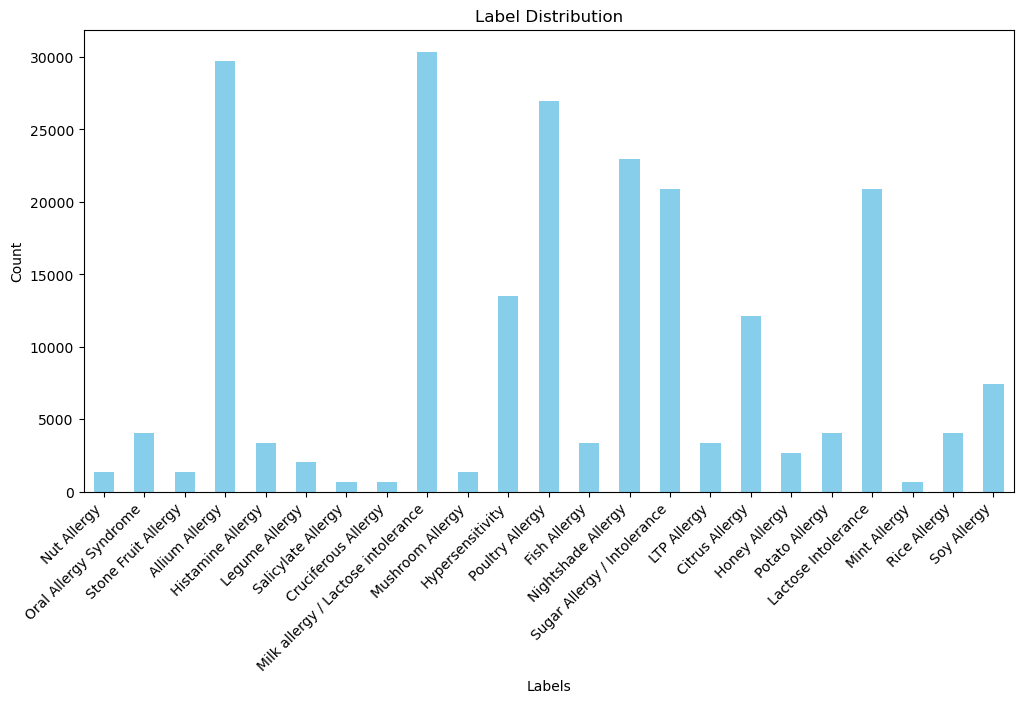

Minimum label count: 675


(23,
 Nut Allergy                            1350
 Oral Allergy Syndrome                  4050
 Stone Fruit Allergy                    1350
 Allium Allergy                        29700
 Histamine Allergy                      3375
 Legume Allergy                         2025
 Salicylate Allergy                      675
 Cruciferous Allergy                     675
 Milk allergy / Lactose intolerance    30375
 Mushroom Allergy                       1350
 Hypersensitivity                      13500
 Poultry Allergy                       27000
 Fish Allergy                           3375
 Nightshade Allergy                    22950
 Sugar Allergy / Intolerance           20925
 LTP Allergy                            3375
 Citrus Allergy                        12150
 Honey Allergy                          2700
 Potato Allergy                         4050
 Lactose Intolerance                   20925
 Mint Allergy                            675
 Rice Allergy                           4050
 Soy 

In [91]:
labels = train_df.columns[6:]
label_counts = train_df[labels].sum()
plt.figure(figsize=(12, 6))
label_counts.plot(kind='bar', color='skyblue')
plt.title('Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()
labels_greater_than_3 = label_counts[label_counts > 3]

min_label_count = label_counts.min()
print("Minimum label count:", min_label_count)

len(label_counts), label_counts

In [92]:
SentenceTransformer
train_df.to_csv('./resamplesk_ingredients101/SentenceTransformer_train.csv', index=False)
val_df.to_csv('./resamplesk_ingredients101/SentenceTransformer_val.csv', index=False)
test_df.to_csv('./resamplesk_ingredients101/SentenceTransformer_test.csv', index=False)